# Exam Preparation: Cox-Ingersoll-Ross

## Setup

In [1]:
import numpy as np
from scipy.stats import norm, ncx2, gamma
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Global settings for LaTeX rendering
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.fontset'] = 'cm'

# local
import fixed_income_derivatives as fid

## Plotting ZCB Prices, Spot and Forward Rates

We use the information provided in the text to assign values to the parameter: 

In [2]:
# Cox-Ingersoll-Ross model parameters
r0 = 0.032 # initial interest rate
a = 1.2 # rate of reversion
b = 0.048 # parameter to be used for long run mean
sigma = 0.1 # volatility parameter scaling the diffusion term

# compute array of time to maturities
N, T_max = 20, 10 # maturity up to 10Y
mesh = T_max/N # semi annual
tau = np.array([i*mesh for i in range(0, N+1)])
#print(tau)

Using that Vasicek possess an Affine term structure:

In [3]:
ZCB_prices = fid.zcb_price_cir(r0, a, b, sigma, tau)
spot_rates = fid.spot_rate_cir(r0, a, b, sigma, tau)
forward_rates = fid.forward_rate_cir(r0, a, b, sigma, tau)

Make a plot:

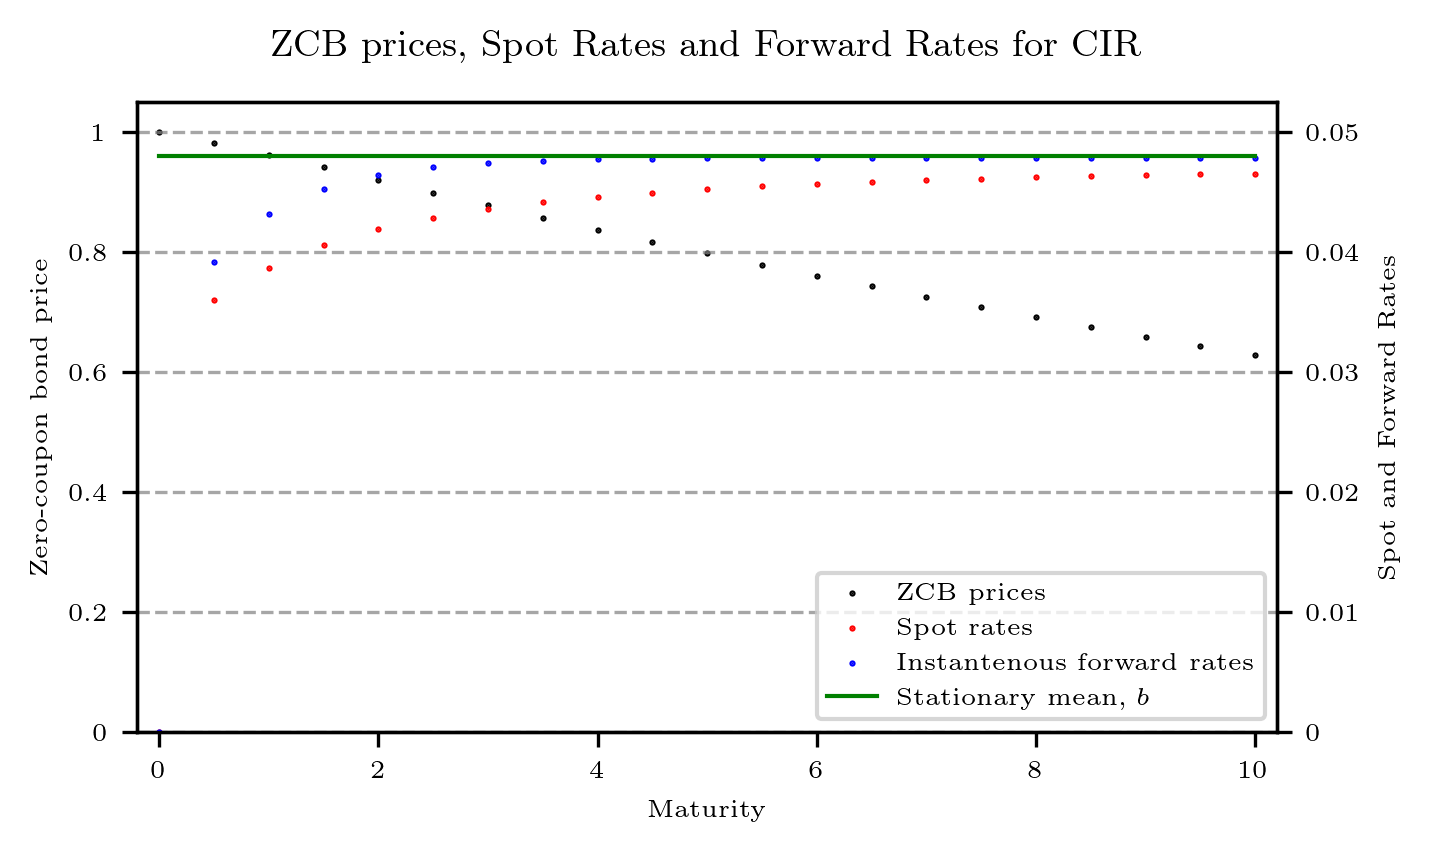

In [4]:
fig = plt.figure(constrained_layout=False, dpi = 300, figsize = (5,3))   #
fig.suptitle(f"ZCB prices, Spot Rates and Forward Rates for CIR", fontsize = 9)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])
#
xticks = [0,2,4,6,8,10]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]-0.2,xticks[-1]+0.2])
plt.xlabel(f"Maturity",fontsize = 6)
ax.set_yticks([0,0.2,0.4,0.6,0.8,1])
ax.set_yticklabels([0,0.2,0.4,0.6,0.8,1],fontsize = 6)
ax.set_ylim([0,1.05])
ax.set_ylabel(f"Zero-coupon bond price",fontsize = 6)
ax.grid(axis='y', linestyle='--', color='grey', alpha=0.7)

p1 = ax.scatter(tau, ZCB_prices, s = 1, color = 'black', marker = ".",label="ZCB prices")

## add second y-axis for the rates
ax1 = ax.twinx()
ax1.set_ylabel(f"Spot and Forward Rates",fontsize = 6)
ax1.set_yticks([0,0.01,0.02,0.03,0.04,0.05,0.06])
ax1.set_yticklabels([0,0.01,0.02,0.03,0.04,0.05,0.06],fontsize = 6)
ax1.set_ylim([0,0.0525])
p2 = ax1.scatter(tau, spot_rates, s = 1, color = 'red', marker = ".",label="Spot rates")
p3 = ax1.scatter(tau, forward_rates, s = 1, color = 'blue', marker = ".",label="Instantenous forward rates")
p4 = ax1.plot(tau, b*np.ones([N+1]), color = 'green', marker = "", linewidth = 1, linestyle = "solid",label = "Stationary mean, $b$")


plots = [p1,p2,p3,p4[0]]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="lower right",fontsize = 6)
plt.show()

* ZCB prices decay
* Term structure of spot rates is upward sloping 
* Current rate of spot rate is below the stationary mean.
* Term structure of Forward rates is typically a bit further ahead.

## Fitting the Model

**Fitting, not knowing $\sigma$**

Using the parameters given above we fit all the parameters in a Vasicek model to the spot rates. 
The purpose is to check if we are able to recover the parameters of the Vasicek model.

In [5]:
param_0 = 0.03, 0.4, 0.05, 0.03  # initial parameters (random guess)

# note, you might need to change tolerance if too many function evaluations
result = minimize(fid.fit_cir_obj, param_0, args=(spot_rates, tau), method='Nelder-Mead', options={'xatol': 1e-12, 'disp': True})

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 242
         Function evaluations: 466


In [6]:
print(f'The fitted values are: r_0 = {result.x[0]:.4f}, a = {result.x[1]:.4f}, b = {result.x[2]:.4f}, and sigma = {result.x[3]:.4f}')
print(f'SSE of the fit {result.fun:.6f}') # not surprisingly, it depends on xatol!

The fitted values are: r_0 = 0.0320, a = 1.2093, b = 0.0478, and sigma = -0.0306
SSE of the fit 0.000000


Fitting the CIR model to spot rates with the objective of recovering all four parameters, we discover that $\sigma$ is difficult to recover implying that $\sigma$ is not well-specified in this model. Despite our inability to recover $\sigma$, we are nonetheless able to recover the remaining parameters $r_0, a$ and $b$ quite well.

**Fitting, knowing $\sigma$**

We do not recover sigma well. So suppose instead we know that sigma is some value. So we remove sigma from param and just put it as an input like "spot_rates" and "tau".

In [7]:
param_0 = 0.03, 0.4, 0.05 # no sigma!
result = minimize(fid.fit_cir_no_sigma_obj,param_0, method= "nelder-mead", args=(sigma, spot_rates,tau), options={'xatol': 1e-12, 'disp': True})

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 209
         Function evaluations: 387


In [8]:
print(f'The fitted values are: r_0 = {result.x[0]:.4f}, a = {result.x[1]:.4f}, b = {result.x[2]:.4f}')
print(f'SSE of the fit {result.fun:.6f}') # not surprisingly, it depends on xatol!

The fitted values are: r_0 = 0.0320, a = 1.2000, b = 0.0480
SSE of the fit 0.000000


If we fit the CIR model to spot rates assuming that $\sigma=0.02$ is known the algorithm will converge very fast and the remaining parameters be returned with high accuracy illustrating once again that $r_0, a$ and $b$ are very will identified in the model

## Simulating

Now we will simulate short rates in the CIR model using the usual first order Euler scheme on a grid of mesh $\delta$ that runs from initial time $t_0=0$ to terminal time $T=10$. Denote by $M$, the number of steps in your simulation. The time points in your simulation will be numbered $m=0,1,2, \ldots, M-1, M$ and the time points will be $\left[t_0, t_1, \ldots, t_{M-1}, t_M\right]=[0, \delta, 2 \delta, \ldots, T-\delta, T]$ and $\delta=\frac{T}{M}$. The scheme you will need to implement is a simple Euler first-order scheme of the form
$$
r_m=r_{m-1}+a\left(b-r_{m-1}\right) \delta+\sigma \sqrt{r_{m-1}} \sqrt{\delta} Z_m, \quad m=1,2, \ldots, M
$$
where $Z_m \sim N(0,1), m=1, \ldots, M$ and all the standard normal random variables are independent.

### Simulating One Trajectory

In [10]:
r0, a, b, sigma = 0.032, 1.2, 0.048, 0.1
size_ci = 0.95 # confidence interval
T, N = 10, 50_000 # maturity, time steps 
param = (a,b,sigma)
delta = T/N # step size
r = fid.short_rate_simul(r0,param,N,T,method = "cir")
tau = np.array([i*delta for i in range(0,N+1)])

# confidence bounds
N_ci = 100 # need to be a large number
t_ci = [i*T/N_ci for i in range(0,N_ci+1)]
lb,ub = fid.ci_cir(r0,a,b,sigma,t_ci,size_ci,method = "two_sided") # lower & upper bound
alpha, beta = (2*a*b)/(sigma**2), sigma**2/(2*a)
lb_sd, ub_sd = gamma.ppf(0.025, alpha, loc=0, scale=beta)*np.ones([N_ci+1]), gamma.ppf(0.975, alpha, loc=0, scale=beta)*np.ones([N_ci+1])

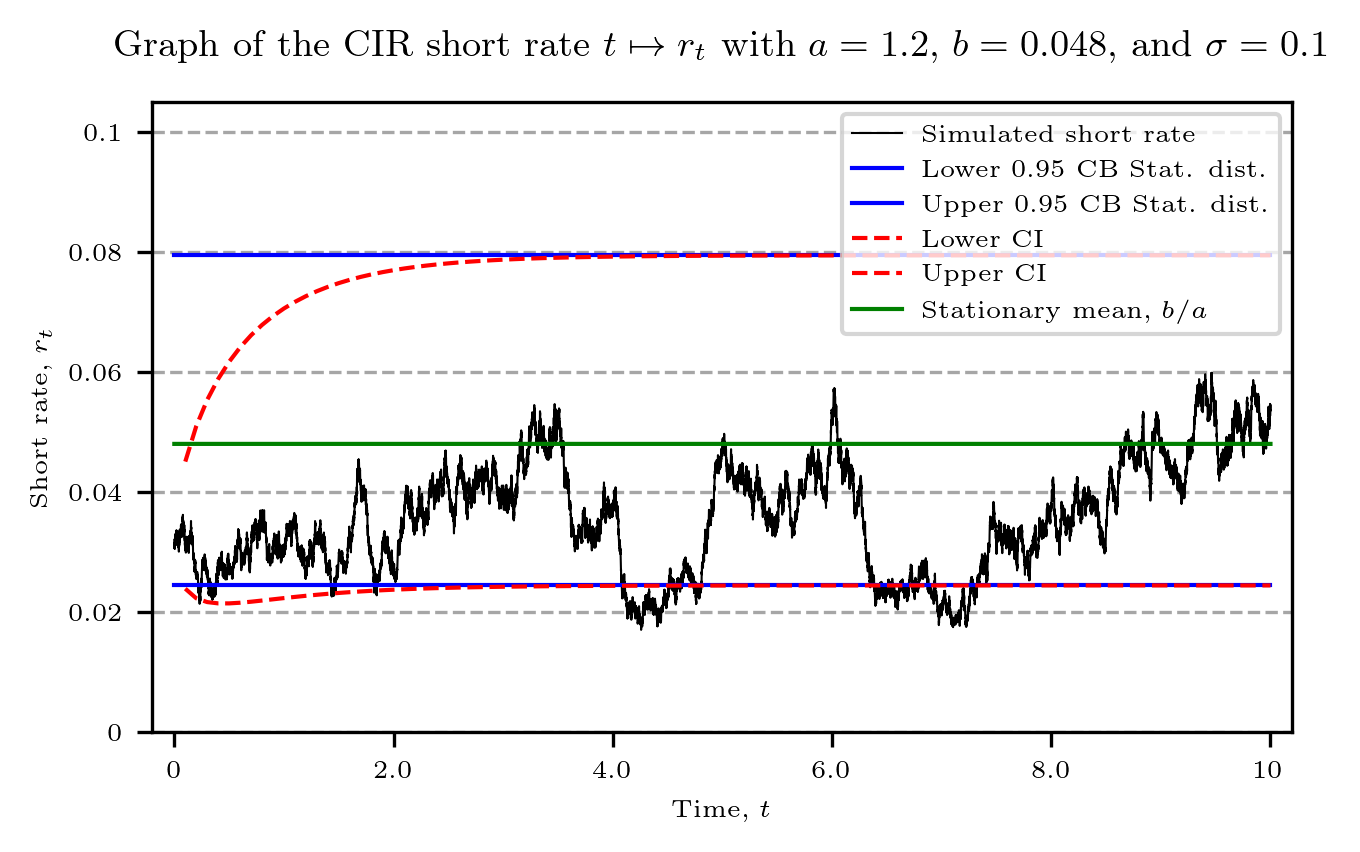

In [11]:
fig = plt.figure(constrained_layout=False, dpi = 300, figsize = (5,3))   #
fig.suptitle(f"Graph of the CIR short rate $t \mapsto r_t$ with $a={a}$, $b={b}$, and $\sigma={sigma}$", fontsize = 9)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])
ax.grid(axis='y', linestyle='--', color='grey', alpha=0.7)


xticks = [0,(1/5)*T,(2/5)*T,(3/5)*T,(4/5)*T,T]
xticklabels = [round(i,3) for i in xticks]
yticks = [0,0.02,0.04,0.06,0.08,0.1]

ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels,fontsize = 6)
ax.set_xlim([xticks[0]-0.2,xticks[-1]+0.2])
plt.xlabel(f"Time, $t$",fontsize = 6)
ax.set_yticks(yticks)
ax.set_yticklabels(yticks,fontsize = 6)
ax.set_ylim([yticks[0],yticks[-1]*1.05])
ax.set_ylabel(f"Short rate, $r_t$",fontsize = 6)

# simulated short rate
ax.plot(tau, r, color = 'black', marker = "",linewidth = 0.5, label = "Simulated short rate")

# stationary CI
ax.plot(t_ci,lb_sd,color = 'blue',marker = "", linewidth = 1, label = "Lower 0.95 CB Stat. dist.")
ax.plot(t_ci,ub_sd,color = 'blue',marker = "", linewidth = 1, label = "Upper 0.95 CB Stat. dist.")

# Simulated CI
ax.plot(t_ci, lb, color = 'red', marker = "", linewidth = 1, linestyle = "dashed", label = "Lower CI")
ax.plot(t_ci, ub, color = 'red', marker = "", linewidth = 1, linestyle = "dashed", label = "Upper CI")

# stationary mean
ax.plot(tau, b*np.ones([N+1]), color = 'green', marker = "", linewidth = 1, linestyle = "solid",label = "Stationary mean, $b/a$")


ax.legend(loc = "upper right",fontsize = 6)
plt.show()

* Confidencen bounds should narrow as it comes closer to the bounds of the statioanry distribution.

The value $r_3$ in the simulation is the short three years after the initial point, and since the confidence interval of $r_3$ is close to that of the stationary distribution, we can conclude that after 3 years the short rate has most likely almost settled to its stationary distribution. Convergence to the stationary distribution will be faster if either $a$ is large or $\sigma$ is small.

c) the relationship between 6m forward rate and par-swap. The par-swap rate is the weighted average of 6m forward rates!

To find price of caplet we sum the reuslts